In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Check missing data

In [77]:
def check_target_balance(data, target_column):
    """
    Check the balance of the target variable.
    """
    target_balance = data[target_colum].value_counts(normalize=True)
    return target_balance

def check_missing_values(data):
    """
    Check for missing values in the dataset.
    """
    missing_values = data.isnull().sum()
    return missing_values[missing_values > 0]

def fill_missing_values(data):
    """
    Fill missing values in the dataset.
    - Drop rows with missing values in critical columns.
    - Fill categorical columns with the mode.
    - Fill numerical columns with the median.
    """
 
    # Fill missing categorical values with the mode
    for column in ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']:
        data[column].fillna(data[column].mode()[0], inplace=True)

    # Fill missing numerical values with the median
    for column in ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
        data[column].fillna(data[column].median(), inplace=True)

    return data


KNN imputing

In [ ]:
def fill_missing_values_with_knn(data, categorical_columns, numerical_columns, n_neighbors=5):
    """
    Impute missing values for both categorical and numerical variables using KNN Imputation.
    
    Parameters:
    - data: The dataframe with missing values.
    - categorical_columns: List of categorical column names.
    - numerical_columns: List of numerical column names.
    - n_neighbors: Number of neighbors to use for KNN imputation (default is 5).
    
    Returns:
    - data: The dataframe with imputed missing values.
    """
    # Create a copy of the data to avoid altering the original dataset
    data_copy = data.copy()

    # Temporarily encode categorical variables using LabelEncoder
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        data_copy[col] = le.fit_transform(data_copy[col].astype(str))
        label_encoders[col] = le

    # Apply KNNImputer for both categorical and numerical columns
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_data = pd.DataFrame(knn_imputer.fit_transform(data_copy), columns=data_copy.columns)

    # Reverse the encoding for categorical variables
    for col in categorical_columns:
        imputed_data[col] = imputed_data[col].round().astype(int)
        imputed_data[col] = label_encoders[col].inverse_transform(imputed_data[col])

    # Return the imputed dataset
    return imputed_data

# Standadise data

In [78]:
def standardize_numerical_columns(data):
    """
    Standardize numerical columns in the dataset using z-score normalization.
    
    Parameters:
    - data: The dataframe containing the data.
    - numerical_columns: List of numerical column names to be standardized.
    
    Returns:
    - data: The dataframe with standardized numerical columns.
    """
    
    # Define the numerical columns that you want to standardize
    numerical_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    # Create a copy of the data to avoid altering the original dataset
    data_copy = data.copy()

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Standardize the numerical columns
    data_copy[numerical_columns] = scaler.fit_transform(data_copy[numerical_columns])

    return data_copy

Feature Engineering

In [79]:
def feature_engineering(data):
    """
    Perform feature engineering on the dataset.
    - Split 'Cabin' into 'Deck', 'CabinNumber', and 'Side'.
    - Create 'TotalSpend' feature.
    - Create 'AgeGroup' feature.
    """
    # Split 'Cabin' into 'Deck', 'CabinNumber', and 'Side'
    data[['Deck', 'CabinNumber', 'Side']] = data['Cabin'].astype(str).str.split('/', expand=True)
    data['CabinNumber'] = pd.to_numeric(data['CabinNumber'], errors='coerce')
    # data = data.drop(columns=['Cabin'])

    # Create 'TotalSpend' feature
    data['TotalSpend'] = (
        data['RoomService'] +
        data['FoodCourt'] +
        data['ShoppingMall'] +
        data['Spa'] +
        data['VRDeck']
    )

    # Create age groups
    bins = [0, 12, 18, 35, 60, 100]
    labels = ['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior']
    data['AgeGroup'] = pd.cut(data['Age'], bins=bins, labels=labels)
    
    # Ensure 'Name' column contains strings and handle missing values
    data['Name'] = data['Name'].astype(str).fillna('Unknown Unknown')
    
    # Split 'Name' into a list of strings
    name_split = data['Name'].str.split(' ', n=1, expand=True)  # Split only at the first space
    
    # Assign the first part as 'FirstName' and the second part as 'Surname'
    data['FirstName'] = name_split[0]
    data['Surname'] = name_split[1].fillna('Unknown')

    return data

Categorical variables encoding

In [80]:
def encode_categorical_features(data):
    """
    Encode categorical features using LabelEncoder.
    """
    label_encoder = LabelEncoder()
    for column in ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Name', 'Deck', 'Side', 
                   'AgeGroup', 'FirstName', 'Surname', 'Cabin']:
        data[column] = label_encoder.fit_transform(data[column].astype(str))
    
    return data

Preprocess data 

In [81]:
def preprocess_data(data, target_column='Transported'):
    """
    Perform the full preprocessing pipeline on the dataset.
    """
    data = fill_missing_values(data)

    # Step 2: Perform feature engineering
    data = feature_engineering(data)
        # Apply the function to standardize numerical columns
    data = standardize_numerical_columns(data)
    # Step 3: Encode categorical variables
    data = encode_categorical_features(data)

    # Step 4: Check target variable balance
    target_balance = check_target_balance(data, target_column)
    print("Target Balance:\n", target_balance)

    return data


Preditions

In [82]:
def prediction_results(model, data_path='test.csv', output_path='predictions.csv'):
    """
    Process the dataset, make predictions using the provided model, and save the results to a CSV file.
    
    Parameters:
    - data_path: Path to the dataset to be processed.
    - model: Trained machine learning model to use for predictions.
    - output_path: Path to save the prediction results.
    """
    # Load the dataset
    data = pd.read_csv(data_path)
    data['Transported'] = False
    data = preprocess_data(data)
    passenger_ids = data['PassengerId']
    data = data.drop(columns=['PassengerId', 'Transported', 'Name', 'VIP', 'FirstName'])
    predictions = model.predict(data)
    
    # Ensure predictions are a 2D array
    if predictions.ndim == 1:
        predictions = predictions.reshape(-1, 1)
    
    # Convert float predictions to 'True' or 'False' if needed
    if predictions.dtype == np.float32:
        predictions = np.where(predictions > 0.5, 'True', 'False')
    # Create a DataFrame with PassengerId and Transported predictions
    output = pd.DataFrame({'PassengerId': passenger_ids, 'Transported': predictions.flatten()})
    output.to_csv(output_path, index=False)
    
    # return output


Data 

In [83]:
spaceship_data = pd.read_csv('train.csv')
spaceship_data.head()

check_missing_values(spaceship_data)
spaceship_data = preprocess_data(spaceship_data)

# Split the dataset into features and target
X = spaceship_data.drop(columns=['PassengerId', 'Transported', 'Name', 'VIP', 'FirstName'])
y = spaceship_data['Transported']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\shami\AppData\Local\Temp\ipykernel_6136\4023693095.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mode()[0], inplace=True)
C:\Users\shami\AppData\Local\Temp\ipykernel_6136\4023693095.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[column].fillna(data[col

Target Balance:
 Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64


# Models
1. Random Forrest

Fitting 3 folds for each of 324 candidates, totalling 972 fits


C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
324 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
246 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base

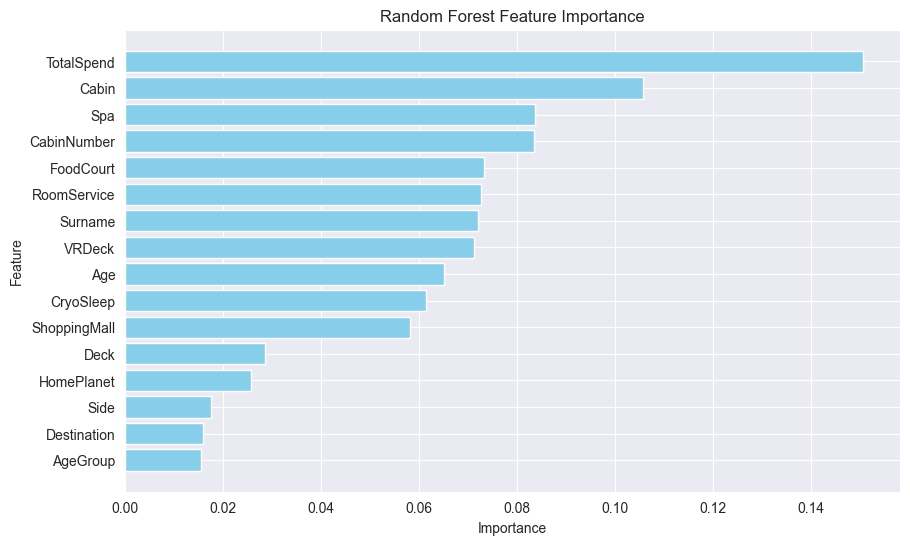

C:\Users\shami\AppData\Local\Temp\ipykernel_6136\2307641430.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mode()[0], inplace=True)
C:\Users\shami\AppData\Local\Temp\ipykernel_6136\2307641430.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[column].fillna(data[col

Target Balance:
 Transported
False    1.0
Name: proportion, dtype: float64


In [74]:
# Define the parameter grid for RandomForest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_model_rf = grid_search.best_estimator_

y_pred_best = best_model_rf.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)
best_params, accuracy_best, report_best

# featjure importance 
# Extract feature importances
importances = best_model_rf.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': X_train.columns.tolist(),
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()

prediction_results(model=best_model_rf)

2. Ensemble methods (Stacking), improved from 80% to 80.36%

In [72]:
# 1. Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
report_gb = classification_report(y_test, y_pred_gb)

# 2. XGBoost
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)

# 3. Stacking Classifier
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'))
]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=3)
stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)
accuracy_stack = accuracy_score(y_test, y_pred_stack)
report_stack = classification_report(y_test, y_pred_stack)

# Results
print("Gradient Boosting Accuracy:", accuracy_gb)
print(report_gb)
print("XGBoost Accuracy:", accuracy_xgb)
print(report_xgb)
print("Stacking Classifier Accuracy:", accuracy_stack)
print(report_stack)

prediction_results(model=stacking_model)

C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:41:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:41:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:41:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Gradient Boosting Accuracy: 0.8021851638872916
              precision    recall  f1-score   support

       False       0.83      0.76      0.79       861
        True       0.78      0.84      0.81       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739

XGBoost Accuracy: 0.7987349051178838
              precision    recall  f1-score   support

       False       0.83      0.75      0.79       861
        True       0.77      0.85      0.81       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739

Stacking Classifier Accuracy: 0.7993099482461185
              precision    recall  f1-score   support

       False       0.81      0.77      0.79       861
        True       0.79      0.83      0.81       878

    accuracy                           0.80      

C:\Users\shami\AppData\Local\Temp\ipykernel_6136\2307641430.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mode()[0], inplace=True)
C:\Users\shami\AppData\Local\Temp\ipykernel_6136\2307641430.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[column].fillna(data[col

4. Gradient boost with grid search

In [73]:
# Define the parameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}


gb_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_gb_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_gb = best_gb_model.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Accuracy: {accuracy_gb}")

# Classification report
report_gb = classification_report(y_test, y_pred_gb)
report_gb

prediction_results(model=best_gb_model)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Accuracy: 0.8021851638872916
Target Balance:
 Transported
False    1.0
Name: proportion, dtype: float64


C:\Users\shami\AppData\Local\Temp\ipykernel_6136\2307641430.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mode()[0], inplace=True)
C:\Users\shami\AppData\Local\Temp\ipykernel_6136\2307641430.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[column].fillna(data[col

### Neural networks

In [ ]:
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())  # Add Batch Normalization for faster convergence
model.add(Dropout(0.4))  # Increased dropout rate to prevent overfitting
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0005)  # Lower learning rate for more fine-tuned updates
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping with increased patience
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=32, callbacks=[early_stopping], verbose=2)

# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

prediction_results(model=model)